# **Projeto de previsão de rotatividade de usuários (churn) no Waze através de Regressão Logística**

## **Objetivo**

Neste projeto, estaremos desenvolvendo e avaliando um modelo de regressão logística binomial com o propósito de antecipar a rotatividade de usuários do aplicativo Waze, utilizando diversas variáveis como base para a previsão.

A rotatividade de clientes, também conhecida como churn, é uma taxa que reflete a quantidade de receita ou clientes que uma empresa perdeu ao longo de um determinado período. Compreender por que os clientes utilizam o aplicativo, e mais crucialmente, por que deixam de usá-lo, é essencial para determinar o momento adequado para ação e para implementar estratégias visando evitar a perda de usuários. 

A regressão logística é uma ferramenta valiosa para estimar a probabilidade de um resultado. Sua utilidade reside na capacidade de considerar múltiplas variáveis em relação à variável que está sendo medida.

O projeto é organizado da seguinte forma: 

1. Análise exploratótia de dados.
3. Pressupostos de regressão logística.
4. Desenvolvimento e avaliação de modelo.
5. Interpretando os resultados do modelo.
6. Conclusões finais.

Cada etapa desempenha um papel crucial na compreensão da dinâmica da rotatividade de usuários no aplicativo Waze, permitindo uma abordagem mais informada e estratégica para mitigar a perda de clientes.

No próximo projeto, abordaremos o mesmo tema utilizando técnicas de aprendizado de máquina.

## Análise exploratória de dados 

A análise exploratória de dados permite identificar padrões, tendências e relações entre as variáveis, oferecendo insights valiosos para a construção do modelo preditivo. Durante esse processo, enfrentamos desafios associados à presença de valores ausentes e outliers, uma vez que esses elementos podem exercer um impacto significativo no desempenho de um modelo de regressão logística. Realizamos os passos fundamentais na construção de um modelo robusto, incluindo:

* visualização de dados;
* criação de variáveis novas;
* solução do problema de valores ausentes e outliers;
* codificação de variáveis categóricas;
* normalização dos dados.

Começamos com a importação dos pacotes e bibliotecas necessários para construir e avaliar modelo de regressão logística.

In [1]:
# Pacotes de processamento de dados

import pandas as pd
import numpy as np

# Pacotes de visualização de dados

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Pacotes para regressão logística e matriz de confusão

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

# Pacote para balanceamento de classes
from sklearn.base import OneToOneFeatureMixin
from imblearn.under_sampling import RandomUnderSampler

In [2]:
# Abrimos os dados

df = pd.read_csv('waze_dataset.csv')

Os dados foram obtidos através do curso do Google "Advanced Data Analytics Certification" em parceria com o Waze.

In [3]:
df.head(10)

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android
5,5,retained,113,103,279.544437,2637,0,0,901.238699,439.101397,15,11,iPhone
6,6,retained,3,2,236.725314,360,185,18,5249.172828,726.577205,28,23,iPhone
7,7,retained,39,35,176.072845,2999,0,0,7892.052468,2466.981741,22,20,iPhone
8,8,retained,57,46,183.532018,424,0,26,2651.709764,1594.342984,25,20,Android
9,9,churned,84,68,244.802115,2997,72,0,6043.460295,2341.838528,7,3,iPhone


### Legendas


`ID` índice sequencial.

`label` variável binária ("retained" e "churned") para indicar se um usuário parou de usar o aplicativo a qualquer momento durante o mês. "Retained" significa que um usuário foi "mantido", "churned" - abandonou/parou de usar o app.

`sessions` quantas vezes um usuário abriu o aplicativo durante o mês.

`drives` ocorrência de corridas de pelo menos 1 km durante o mês.

`total_sessions` uma estimativa do número total de sessões desde que um usuário começou usar o aplicativo.

`n_days_after_onboarding` número de dias desde que um usuário se cadastrou no aplicativo.

`total_navigations_fav1` número total de corridas até o primeiro local favorito do usuário.

`total_navigations_fav2` número total de corridas até o segundo local favorito do usuário.

`driven_km_drives` número total de quilômetros rodados durante o mês.

`duration_minutes_drives` duração total de corridas em minutos durante o mês.

`activity_days` número de dias que o usuário abre o aplicativo durante o mês.

`driving_days` número de dias que o usuário dirige (pelo menos 1 km) durante o mês.

`device`  o tipo de dispositivo ("android" ou "iphone") utilizado por um usuário para iniciar uma sessão no aplicativo. 

Dado nosso foco na rotatividade de usuários, a coluna `label` é fundamental. Além de `label`, as variáveis relacionadas ao comportamento do usuário são as mais pertinentes. Todas as variáveis estão associadas ao comportamento do usuário, com exceção do `ID`.

Outliers (_valores atípicos_) e valores extremos podem impactar significativamente os modelos de regressão logística. É importante identificar e compreender outliers para garantir uma interpretação mais precisa e robusta dos dados. Para isso vamos substituir dados extremos por dados médios, identificar valores ausentes e/ou remover valores maiores que 3 desvios padrão. 

Além disso, pode ser útil criar novas variáveis multiplicando-as ou calculando a razão entre duas variáveis. Por exemplo, nesse projeto podemos criar uma variável `drives_sessions_ratio` dividindo corridas (`drives`) por sessões (`sessions`).

Verificamos a estrutura de dados através de `shape` e `info`.

In [4]:
df.shape

(14999, 13)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


A coluna `label` apresenta $700$ valores ausentes, mas abordaremos essa questão mais adiante. 

Primeiro, vamos excluir a coluna `ID` utilizando o método `drop()`, uma vez que essa informação não é necessária para a análise em questão.

In [6]:
df = df.drop('ID', axis=1)

Analisamos o balanceamento das amostras das classes da variável dependente `label`:

In [7]:
round(df.label.value_counts()/df.shape[0] * 100,3)

label
retained    78.425
churned     16.908
Name: count, dtype: float64

Observamos que as classes da `label` são desbalanceadas, com 16,90% de churn. Visualizamos a distribuição da classes.

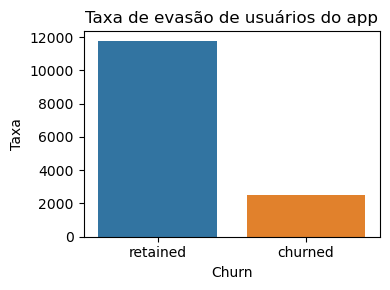

In [9]:
# Gráfico de barras 

plt.figure(figsize=(4,3))
count = df['label'].value_counts()
g = sns.countplot(x='label', data=df)
g.set_xlabel('Churn')
g.set_ylabel('Taxa')
g.set_title('Taxa de evasão de usuários do app');
plt.tight_layout()

O desbalanceamento nas amostras das classes é bastante comum em diversos setores e campos do conhecimento. Mesmo que os dados desbalanceados tenham potencial destrutivo na criação de modelos, nem sempre se mostram tão nocivos em determinadas áreas da Ciência de Dados. 

Exploramos as estatísticas descritivas dos dados com o objetivo de identificar possíveis valores atípicos (outliers).

In [10]:
# Verificamos as estatísticas descritivas dos dados

df.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,80.633776,67.281152,189.964447,1749.837789,121.605974,29.672512,4039.340921,1860.976012,15.537102,12.179879
std,80.699065,65.913872,136.405128,1008.513876,148.121544,45.394651,2502.149334,1446.702288,9.004655,7.824036
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000
50%,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000
75%,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000
max,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000


Ao analisar os números, observamos que as seguintes colunas apresentam valores máximos que ultrapassam consideravelmente o $75º$ percentil por múltiplos desvios padrão:


* `sessions`
* `drives`
* `total_sessions`
* `total_navigations_fav1`
* `total_navigations_fav2`
* `driven_km_drives`
* `duration_minutes_drives`

Essa observação sugere a possível presença de outliers nessas variáveis.

### Visualização de dados


Iniciamos nossa análise ao examinar a distribuição de seguintes variáveis numéricas por meio de histogramas: `sessions`, `drives`, `total_sessions`, `activity_days` e `driving_days`.

Começamos com o historgrama da variável `sessions`(quantas vezes um usuário abriu o aplicativo durante o mês).

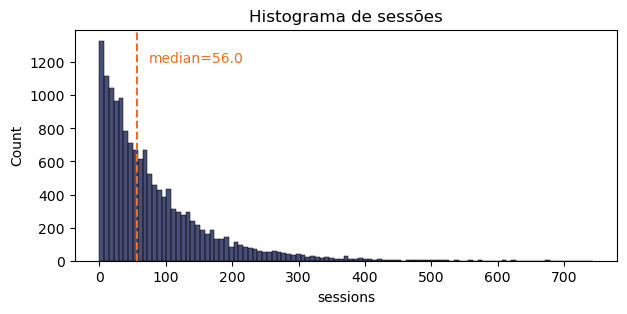

In [11]:
# Histograma 

plt.figure(figsize=(7,3))
sns.histplot(x=df['sessions'], color='#0a1247')
median = df['sessions'].median()
plt.axvline(median, color='#f06d22', linestyle='--')
plt.text(75,1200, 'median=56.0', color='#f06d22')
plt.title('Histograma de sessões');

A variável `sessions` apresenta uma distribuição assimétrica enviesada à direita. A mediana sugere que metade dos usuários possui $56$ sessões ou menos. Além disso, de acordo com as estatísticas descritivas mencionadas anteriormente, o histograma corrobora a presença de alguns usuários com mais de $700$ sessões.

Para aumentar a eficiência, vamos criar uma função que construa o histograma e, assim, utilizá-la sempre que necessário.

In [12]:
# Função auxilar para construção de histograma

def histogramas(column_str, median_text=True, **kwargs):    # **kwargs = argumentos de palavra-chave
                                                             
    median=round(df[column_str].median(), 1)
    plt.figure(figsize=(7,3))
    ax = sns.histplot(x=df[column_str], color='#0a1247', **kwargs)            # Plotar o histograma
    plt.axvline(median, color='#f06d22', linestyle='--')      # Adicionar a linha mediana
    if median_text==True:                                    # Adicionar texto a mediana
        ax.text(0.25, 0.85, f'median={median}', color='#f06d22',
            ha='left', va='top', transform=ax.transAxes)
    else:
        print('Median:', median)
    plt.title(f'{column_str} histogram');

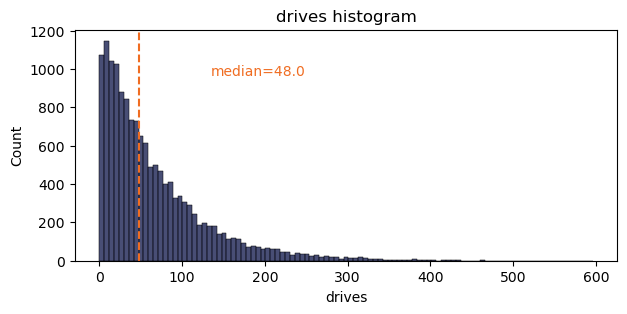

In [23]:
# Histograma para coluna `drives` 

histogramas('drives')

As informações da coluna `drives` seguem uma distribuição semelhante à coluna de `sessions`. É inclinado para a direita, seguindo (aproximadamente) uma distribuição log-normal, com uma mediana de $48$. No entanto, alguns motoristas realizaram mais de $400$ corridas no último mês.

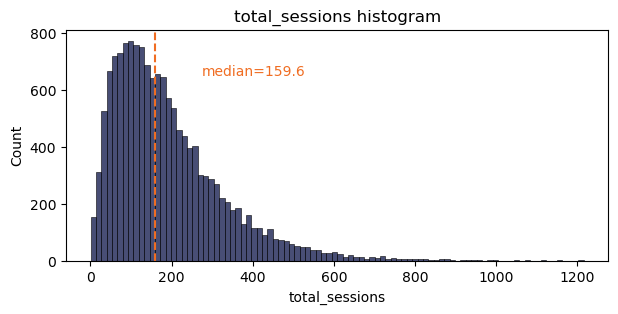

In [24]:
# Histograma da coluna `total_session`, número total de sessões desde que um usuário começou usar o aplicativo

histogramas('total_sessions')

A mediana do número total de sessões é $159,6$. É uma informação interessante: a média de sessões no último mês sendo $56$, e a média total de sessões aproximadamente $160$, sugere que uma considerável proporção do total de corridas de um usuário pode ter ocorrido no último mês. 

Median: 16.0


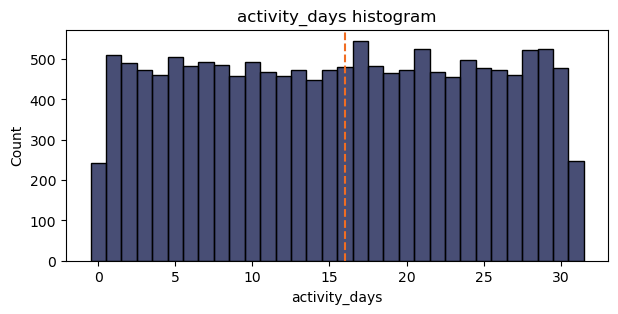

In [25]:
# Histograma do número de dias que o usuário abre o aplicativo durante o mês

histogramas('activity_days', median_text=False, discrete=True)

No último mês, a média de aberturas do aplicativo por usuário foi de 16 vezes. O histograma revela uma distribuição (quase) uniforme, com aproximadamente 500 pessoas abrindo o aplicativo em cada contagem de dias. No entanto, é notável que existem cerca de 250 pessoas que não abriram o aplicativo e outras 250 que o abriram todos os dias do mês.

Essa distribuição é interessante porque não reflete a distribuição da `sessions`, que poderia ser correlacionada com a `activity_days`.

Median: 12.0


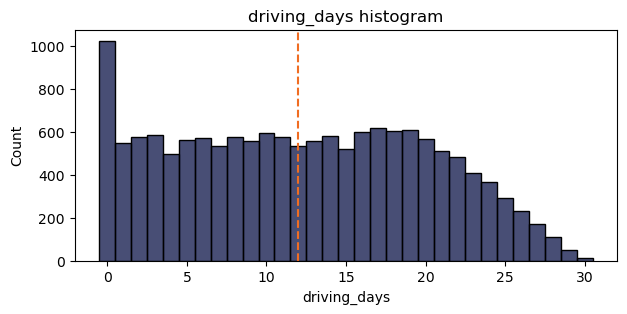

In [26]:
# Histograma do número de dias que o usuário dirige (pelo menos 1 km) durante o mês

histogramas('driving_days', median_text=False, discrete=True)

O número de dias em que os usuários dirigiram em cada mês (`driving_days`) é quase uniforme e está em grande parte correlacionado com o número de dias em que abriram o aplicativo naquele mês (`activity_days`). No entanto, é importante notar que a distribuição de `driving_days` diminui à medida que nos deslocamos para a direita.

Dado que `driving_days` e `activity_days` representam contagens de dias ao longo de um mês e estão relacionados, podemos representá-los conjuntamente em um único histograma. 

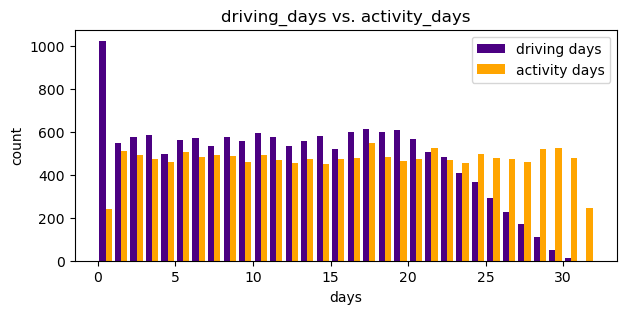

In [24]:
# Histograma `driving_days` vs `activity_days`

plt.figure(figsize=(7,3))
label=['driving days', 'activity days']
plt.hist([df['driving_days'], df['activity_days']], color=['indigo','orange'],
         bins=range(0,33),
         label=label)
plt.xlabel('days')
plt.ylabel('count')
plt.legend()
plt.title('driving_days vs. activity_days');

O histograma parece contraditório: há menos pessoas que não usaram o aplicativo durante o mês, mas mais pessoas que não dirigiram durante o mesmo período? Este é mais um exemplo de que, embora essas variáveis estejam relacionadas, elas não são idênticas. É possível que as pessoas abram o aplicativo mais vezes do que o usam para dirigir, talvez para verificar o tempo de percurso, informações de rota, condições de tráfego, atualizar configurações ou até mesmo por engano.

Uma abordagem adicional para avaliar a validade dessas variáveis é criar um gráfico de dispersão, onde o eixo $x$ representa uma variável e o eixo $y$ representa a outra. Isso pode proporcionar uma visualização mais clara das relações entre as duas variáveis.

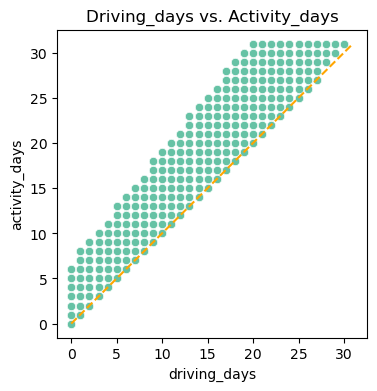

In [34]:
# Gráfico de dispersão driving_days vs. activity_days

plt.figure(figsize=(4,4))
sns.set_palette(sns.color_palette("Set2"))
sns.scatterplot(data=df, x='driving_days', y='activity_days')
plt.title('Driving_days vs. Activity_days')
plt.plot([0,31], [0,31], color='orange', linestyle='--');

É relevante observar que existe um limite teórico: um usuário não pode ter mais dias de condução do que dias de atividade. É positivo notar que nenhuma das amostras nos dados viola essa regra.

Vamos analisar a variável `device`, que indica o tipo de dispositivo ("android" ou "iphone") utilizado por um usuário para iniciar uma sessão no aplicativo. Dado que esta variável é categórica, optamos por utilizar um gráfico de pizza (pie chart) para a visualização.

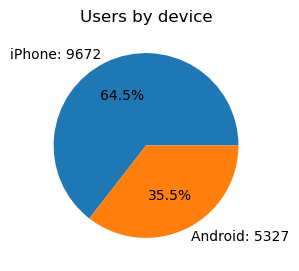

In [29]:
# Pie chart 

fig = plt.figure(figsize=(3,3))
data=df['device'].value_counts()
plt.pie(data,
        labels=[f'{data.index[0]}: {data.values[0]}',
                f'{data.index[1]}: {data.values[1]}'],
        autopct='%1.1f%%'
        )
plt.title('Users by device');

Observamos que há quase o dobro de usuários de iPhone em comparação com usuários de Android, conforme representado nos dados. Sabendo disso, é relevante visualizar quantos usuários de cada categoria deixaram de utilizar o aplicativo. Essa análise pode ajudar a entender melhor como a retenção varia entre os diferentes dispositivos utilizados pelos usuários.

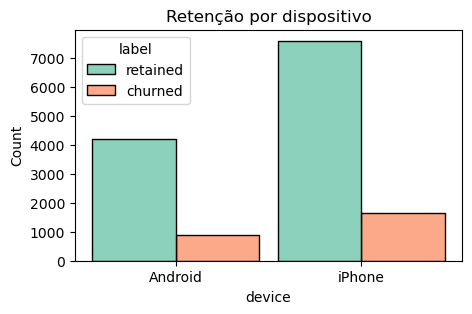

In [33]:
# Histograma

plt.figure(figsize=(5,3))
sns.set_palette(sns.color_palette("Set2"))
sns.histplot(data=df,
             x='device',
             hue='label',
             multiple='dodge',
             shrink=0.9
             )
plt.title('Retenção por dispositivo');

A proporção de usuários deixaram de utilizar o aplicativo em relação aos usuários retidos é consistente entre os dois tipos de dispositivos.

### **Criação de variáveis novas**

Conforme discutido anteriormente, pode ser útil criar novas variáveis por meio da multiplicação ou do cálculo da razão entre duas variáveis. Vamos criar duas novas variáveis que podem ser necessárias para abordar o problema do nosso projeto: `km_per_driving_day` e `professional_driver`.

#### **`km_per_driving_day`**

A taxa de rotatividade de usuários se correlaciona com a distância percorrida por dia no último mês (FONTE?). Vamos criar a coluna com essas informações.

In [27]:
# Criamos a coluna `km_per_driving_day` 
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

# Verificamos a estatística descritiva
df['km_per_driving_day'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

Como observado na análise anterior, a coluna `driving_days` contém valores nulos, o que resulta em valores infinitos na coluna `km_per_driving_day`, uma vez que a divisão por zero é indefinida.

Podemos resolver isso convertendo os valores infinitos a zero, utilizando o método `np.inf`:

In [28]:
# Converter valores infinitos em zero
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0

# Verificamos a estatística
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

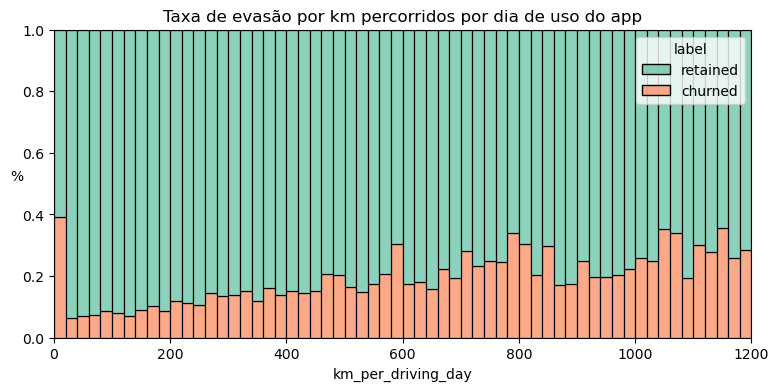

In [32]:
# Visualização da taxa de evasão por km percorridos por dia de uso do app

sns.set_palette(sns.color_palette("Set2"))
plt.figure(figsize=(9,4))
sns.histplot(data=df,
             x='km_per_driving_day',
             bins=range(0,1201,20),
             hue='label',
             multiple='fill')
plt.ylabel('%', rotation=0)
plt.title('Taxa de evasão por km percorridos por dia de uso do app');

A taxa de evasão tende a aumentar à medida que a distância média diária percorrida aumenta. Valeria a pena investigar mais a fundo os motivos que levaram os usuários de longa distância a interromper o uso do aplicativo

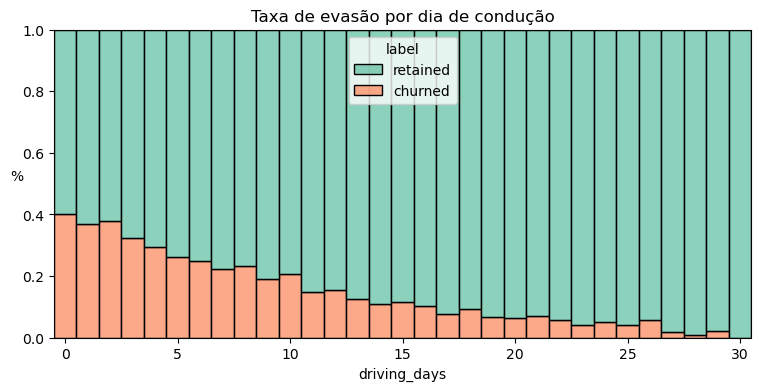

In [31]:
# Visualização da taxa de evasão por dia de condução

sns.set_palette(sns.color_palette("Set2"))
plt.figure(figsize=(9,4))
sns.histplot(data=df,
             x='driving_days',
             bins=range(1,32),
             hue='label',
             multiple='fill',
             discrete=True)
plt.ylabel('%', rotation=0)
plt.title('Taxa de evasão por dia de condução');

A taxa de evasão é mais alta entre os usuários que não utilizaram muito o Waze durante o último mês. Quanto mais vezes eles usam o aplicativo, menor é a probabilidade de abandoná-lo. Apesar de 40% dos usuários que não usaram o aplicativo no último mês o abandonarem, nenhum daqueles que utilizaram o aplicativo por 30 dias parou de usá-lo

#### **`professional_driver`**

Criamos uma nova varável binária `professional_driver` com o objetivo de distinguir motoristas professionais (por exemplo, motoristas de aplicativo) dos usuários comuns. Definimos um motorista profissional como aquele que realizou 60 corridas ou mais <u>**e**</u> dirigiu por 15 dias ou mais no último mês. 

Para criar a coluna usamos a função `np.where()`:

In [35]:
# Criamos a coluna nova 'professional_driver' ('1' indica que motorista é professional)

df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)

In [36]:
# Verificamos a quantidade de motoristas profissionais 
print(df['professional_driver'].value_counts())

# Agrupamos por 'label' para ver quantidade de usuários quem parou de usar o aplicativo 
df.groupby(['professional_driver'])['label'].value_counts(normalize=True)

professional_driver
0    12405
1     2594
Name: count, dtype: int64


professional_driver  label   
0                    retained    0.801202
                     churned     0.198798
1                    retained    0.924437
                     churned     0.075563
Name: proportion, dtype: float64

**A taxa de evasão para os motoristas profissionais é 7.6%, enquanto para não profissionais é 19,9%. Esta informação poderia adicionar um sinal preditivo ao modelo.**

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xlabel'

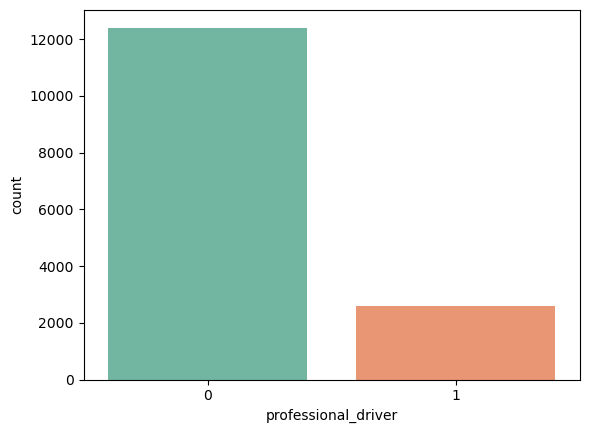

<Figure size 600x600 with 0 Axes>

In [46]:
# Visualizamos a taxa de evasão para motoristas

sns.set_palette(sns.color_palette("Set2"))
#g = sns.countplot(df, x='professional_driver', hue='label')
sns.countplot( x= df['professional_driver'])
plt.figure(figsize=(6, 6))
plt.set_xlabel('Tipo de motorista: "0" não-profissional, "1" profissional')
plt.set_ylabel('Taxa')
plt.set_title('Taxa de evasão do app');
plt.tight_layout();

### Solução do problema de valores ausentes e outliers

Conforme identificado na análise anterior, os dados apresentam valores ausentes e outliers. Vamos abordar esses problemas para garantir uma análise mais robusta e precisa.

A variável `label` tem $700$ valores ausentes, o que representa menos de $5%$ do total de dados, utilizamos o método `dropna()` para eliminar os valores ausentes.

In [47]:
df.isna().sum()

label                      700
sessions                     0
drives                       0
total_sessions               0
n_days_after_onboarding      0
total_navigations_fav1       0
total_navigations_fav2       0
driven_km_drives             0
duration_minutes_drives      0
activity_days                0
driving_days                 0
device                       0
km_per_driving_day           0
professional_driver          0
dtype: int64

In [48]:
df = df.dropna(subset=['label'])
df.isna().sum()

label                      0
sessions                   0
drives                     0
total_sessions             0
n_days_after_onboarding    0
total_navigations_fav1     0
total_navigations_fav2     0
driven_km_drives           0
duration_minutes_drives    0
activity_days              0
driving_days               0
device                     0
km_per_driving_day         0
professional_driver        0
dtype: int64

O problemas com valores ausentes foi resolvido.

Anteriormente, determinamos que sete variáveis apresentam sinais claros de outliers: 

* `sessions`
* `drives`
* `total_sessions`
* `total_navigations_fav1`
* `total_navigations_fav2`
* `driven_km_drives`
* `duration_minutes_drives`

Podemos resolver o problema calculando o 95º percentil de cada coluna e substituindo qualquer valor na coluna que o exceda por esse percentil.

In [49]:
# Resolvendo outliers

for column in ['sessions', 'drives', 'total_sessions', 'total_navigations_fav1',
               'total_navigations_fav2', 'driven_km_drives', 'duration_minutes_drives']:
    threshold = df[column].quantile(0.95)
    df.loc[df[column] > threshold, column] = threshold

df.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,professional_driver
count,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000
mean,76.539688,63.964683,183.717304,1751.822505,114.562767,27.187216,3944.558631,1792.911210,15.544653,12.182530,581.942399,0.173998
std,67.243178,55.127927,118.720520,1008.663834,124.378550,36.715302,2218.358258,1224.329759,9.016088,7.833835,1038.254509,0.379121
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,0.000000,0.000000
25%,23.000000,20.000000,90.457733,878.500000,10.000000,0.000000,2217.319909,840.181344,8.000000,5.000000,136.168003,0.000000
50%,56.000000,48.000000,158.718571,1749.000000,71.000000,9.000000,3496.545617,1479.394387,16.000000,12.000000,273.301012,0.000000
75%,111.000000,93.000000,253.540450,2627.500000,178.000000,43.000000,5299.972162,2466.928876,23.000000,19.000000,558.018761,0.000000
max,243.000000,200.000000,455.439492,3500.000000,422.000000,124.000000,8898.716275,4668.180092,31.000000,30.000000,15420.234110,1.000000


O problema com outliers foi resolvida.

### **Codificando variáveis categóricas**

Vamos realizar a conversão do tipo de dados das variáveis `label` e `device` para binários. Essa modificação é fundamental para a correta aplicação e treinamento de um modelo de regressão logística.

Atribuímos o valor `0` para os usuários `retained` e `1` para os usuários `churned`. 

In [50]:
# Criamos 'label2' como variável binária

df['label2'] = np.where(df['label']=='churned', 1, 0)
df[['label', 'label2']].tail()

<ipython-input-50-4616e09e11fd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label2'] = np.where(df['label']=='churned', 1, 0)


,label,label2
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


Criamos uma nova variável chamada `device2` que codifica os dispositivos do usuário da seguinte forma: `Android` -> `0`, `iPhone` -> `1`.

In [51]:
# Criamos `device2` como variável binária 

df['device2'] = np.where(df['device']=='Android', 0, 1)
df[['device', 'device2']].tail()

<ipython-input-51-15b459afb74c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['device2'] = np.where(df['device']=='Android', 0, 1)


,device,device2
14994,iPhone,1
14995,Android,0
14996,iPhone,1
14997,iPhone,1
14998,iPhone,1


Após a criação das variáveis binárias, as variáveis categóricas label e device não serão mais necessárias para análises futuras; podemos apagá-las.

In [52]:
# Apagamos as variáveis categóricas 

df = df.drop(columns = ['label', 'device'])
df.head()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,professional_driver,label2,device2
0,243,200,296.748273,2276,208,0,2628.845068,1985.775061,28,19,138.360267,1,0,0
1,133,107,326.896596,1225,19,64,8898.716275,3160.472914,13,11,1246.901868,0,0,1
2,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,382.393602,0,0,0
3,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,304.530374,0,0,1
4,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,219.455667,1,0,0


### Normalização dos dados

As variáveis com escalas diferentes (como no nosso caso) afetam a acurácia do modelo. A normalização coloca os dados no intervalo entre 0 e 1 ou -1 e 1, caso haja valores negativos, sem distorcer as diferenças nas faixas de valores. Usamos a função `MinMaxScaler` do `sklearn`.

In [53]:
# Normalização dos dados

scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

df.head()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,professional_driver,label2,device2
0,1.000000,1.000,0.651396,0.649886,0.492891,0.000000,0.290600,0.423126,0.903226,0.633333,0.008973,1.0,0.0,0.0
1,0.547325,0.535,0.717624,0.349256,0.045024,0.516129,1.000000,0.675755,0.419355,0.366667,0.080861,0.0,0.0,1.0
2,0.469136,0.475,0.297225,0.757151,0.000000,0.000000,0.339287,0.342471,0.451613,0.266667,0.024798,0.0,0.0,0.0
3,0.201646,0.200,0.147992,0.003146,0.763033,0.056452,0.096529,0.122350,0.225806,0.100000,0.019749,0.0,0.0,1.0
4,0.345679,0.340,0.369112,0.445652,0.393365,0.040323,0.440104,0.258344,0.870968,0.600000,0.014232,1.0,0.0,0.0


## **Pressupostos de regressão de regressão logística**

Verificar os pressupostos de regressão de regressão logística é crucial para garantir a validade e confiabilidade do modelo. Neste projeto, abordamos as seguintes hipóteses:

* Observações independentes (refere-se a como os dados foram coletados).

* Sem valores discrepantes (outliers) extremos.

* Ausência de colinearidade entre as variáveis preditoras $X$ (são variáveis que permitem predizer uma resposta).

* A relação linear entre $X$ e as probabilidades logarítmicas estimadas da variável dependente y em relação a $X$, ou _logit_ de $y$ (mas a relação entre uma variável preditora e a variável dependente não precisa ser linear).

Para a primeira hipótese, podemos assumir que as observações são independentes para este projeto. A segunda hipótese já foi abordada. A seguir, iremos avaliar a presença de colinearidade, enquanto a última hipótese será verificada após a modelagem.

#### **Colinearidade**

Primeiro, vamos gerar uma matriz de correlação de Pearson. As variáveis altamente correlacionadas podem causar multicolinearidade que pode tornar o modelo instável.

In [54]:
# Matriz de correlação
df.corr(method='pearson')

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,professional_driver,label2,device2
sessions,1.000000,0.996942,0.597189,0.007101,0.001858,0.008536,0.002996,-0.004545,0.025113,0.020294,-0.011569,0.443654,0.034911,0.012704
drives,0.996942,1.000000,0.595285,0.006940,0.001058,0.009505,0.003445,-0.003889,0.024357,0.019608,-0.010989,0.444425,0.035865,0.011684
total_sessions,0.597189,0.595285,1.000000,0.006596,0.000187,0.010371,0.001016,-0.000338,0.015755,0.012953,-0.016167,0.254433,0.024568,0.012138
n_days_after_onboarding,0.007101,0.006940,0.006596,1.000000,-0.002450,-0.004968,-0.004652,-0.010167,-0.009418,-0.007321,0.011764,0.003770,-0.129263,-0.011299
total_navigations_fav1,0.001858,0.001058,0.000187,-0.002450,1.000000,0.002866,-0.007368,0.005646,0.010902,0.010419,-0.000197,-0.000224,0.052322,-0.001316
total_navigations_fav2,0.008536,0.009505,0.010371,-0.004968,0.002866,1.000000,0.003559,-0.003009,-0.004425,0.002000,0.006751,0.007126,0.015032,-0.000275
driven_km_drives,0.002996,0.003445,0.001016,-0.004652,-0.007368,0.003559,1.000000,0.690515,-0.007441,-0.009549,0.344811,-0.000904,0.019767,-0.002091
duration_minutes_drives,-0.004545,-0.003889,-0.000338,-0.010167,0.005646,-0.003009,0.690515,1.000000,-0.007895,-0.009425,0.239627,-0.012128,0.040407,-0.007709
activity_days,0.025113,0.024357,0.015755,-0.009418,0.010902,-0.004425,-0.007441,-0.007895,1.000000,0.947687,-0.397433,0.453825,-0.303851,-0.010221
driving_days,0.020294,0.019608,0.012953,-0.007321,0.010419,0.002000,-0.009549,-0.009425,0.947687,1.000000,-0.407917,0.469776,-0.294259,-0.003859


Construimos um mapa de correlação para visualizar as correlações entre as variáveis da matriz de correlação. O mapa utiliza cores para indicar a intensidade e a direção dessas relações.

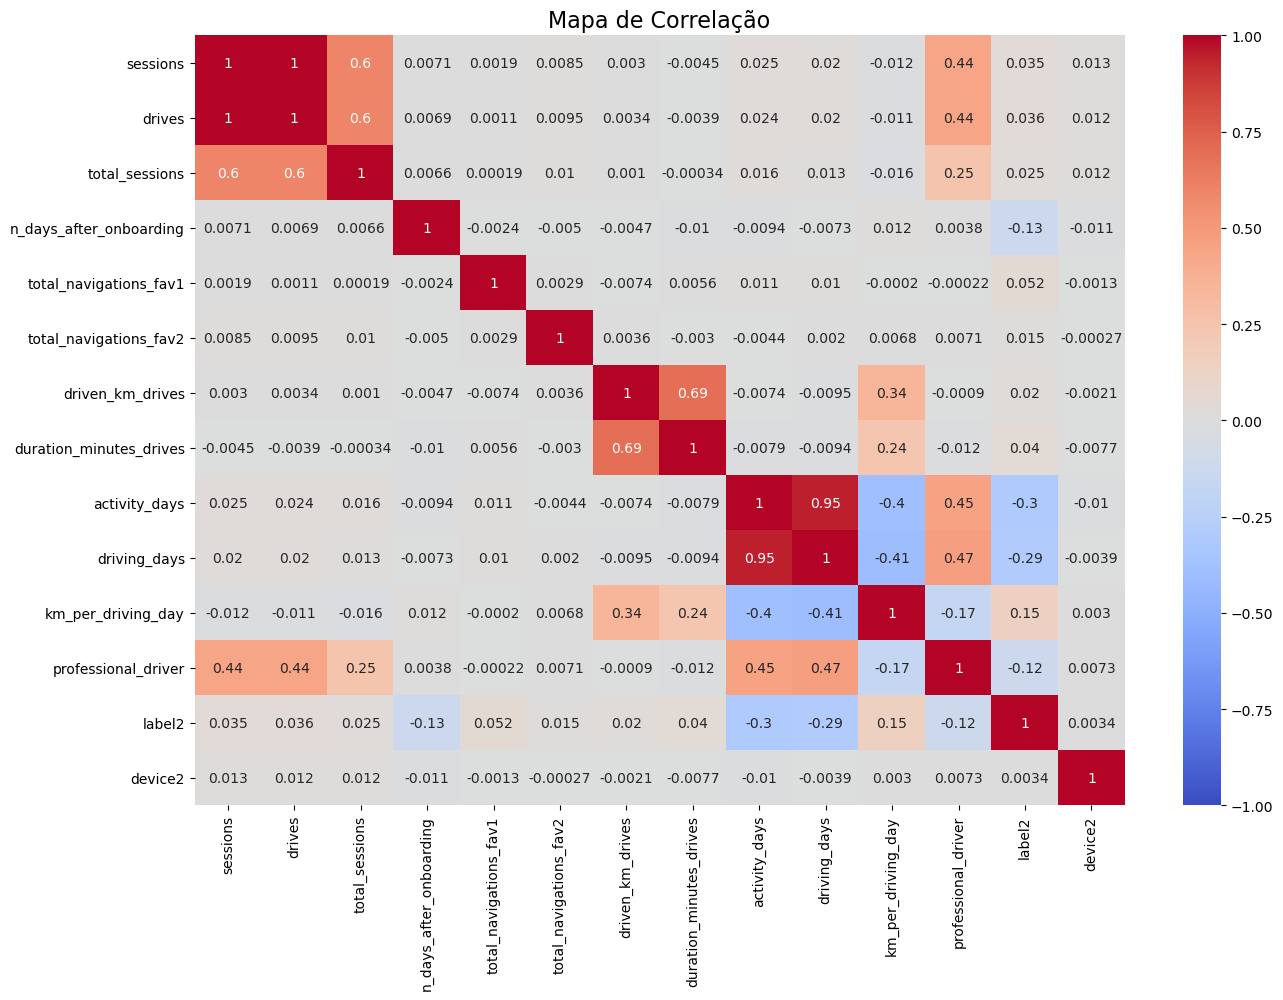

In [55]:
# Mapa de calor de correlação

plt.figure(figsize=(15,10))
sns.heatmap(df.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Mapa de Correlação', fontsize=16)
plt.show();

Observamos que as variáveis `sessions` e `drives` apresentam multicolinearidade, evidenciada pelo coeficiente de correlação igual a $1.0$. Da mesma forma, as variáveis `driving_days` e `activity_days` também exibem  multicolinearidade, com um coeficiente de correlação de $0.95$. 

Estabelecemos um limite inferior para o coeficiente de correlação em $0.7$.

## **Desenvolvimento do modelo**

Nessa seção vamos definir a variável alvo, separar os dados para treinamento e teste, e fazer ajuste do modelo.

Para construir o modelo, é necessário decidir quais variáveis $X$ serão incluídas no modelo para prever a variável alvo `label2`. Eliminamos as seguintes variáveis e atribuimos os resultados a `X`:


* `label2` (alvo)
* `sessions` e `driving_days` (alta multicolinearidade)

Note que optamos por descartar as variáveis `sessions` e `driving_days` em vez de `drives` e `activity_days`. A justificativa para essa escolha reside no fato de que as variáveis mantidas para a modelagem apresentavam correlações ligeiramente mais fortes com a variável alvo em comparação com as variáveis que foram descartadas.

In [56]:
# Isolamos as variáveis preditoras

X = df.drop(columns = ['label2'])

In [57]:
# Definimos a variável alvo

y = df['label2']

Usamos a função [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) do scikit-learn para dividir os dados de treino/teste utilizando as variáveis $X$ e $y$ que foram atribuídas anteriormente. O objetivo é ajustar o modelo utilizando o conjunto de treinamento e, posteriormente, avaliar o desempenho do modelo no conjunto de teste para evitar qualquer vazamento de dados.

Dado o desequilíbrio na classe-alvo (82% "retained" contra 18% "churned"), é crucial garantir que a divisão dos conjuntos de treinamento e teste não enviesadamente represente demais ou sub-represente a frequência da classe minoritária. Para isso, definimos o parâmetro `stratify` da função como `y` para assegurar que a classe minoritária esteja presente nos conjuntos de treinamento e teste na mesma proporção que aparece no conjunto de dados geral.

In [58]:
# Dividimos os dados

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [59]:
# Verificamos

X_train.head()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,professional_driver,device2
147,0.534979,0.540,0.408534,0.890160,0.575829,1.000000,1.000000,1.000000,0.774194,0.500000,0.039708,1.0,1.0
11335,0.008230,0.010,0.007178,0.225973,0.270142,0.145161,0.365015,0.379067,0.161290,0.033333,0.213132,0.0,1.0
10416,0.703704,0.695,0.762020,0.093535,0.009479,0.056452,0.830524,0.501306,0.483871,0.400000,0.039995,0.0,0.0
646,0.539095,0.540,1.000000,0.662471,0.026066,0.032258,0.736115,0.976404,0.580645,0.533333,0.026614,1.0,1.0
8002,0.041152,0.050,0.196072,0.707666,0.319905,0.000000,0.136996,0.197946,0.870968,0.566667,0.004849,0.0,1.0


Utilizamos o scikit-learn para instanciar e ajustar um modelo de regressão logística.

In [60]:
model = LogisticRegression(max_iter=400)

model.fit(X_train, y_train)

LogisticRegression(max_iter=400)

Vamos ver os coeficientes que representam a mudança nas probabilidades logarítmicas da variável alvo para cada aumento de uma unidade em X correspondente. Podemos acessar os coeficientes de cada variável chamando o atributo `.coef_` no modelo de regressão logística. Esses coeficientes estão na mesma ordem em que as variáveis são listadas no conjunto de dados. 

In [61]:
pd.Series(model.coef_[0], index=X.columns)

sessions                  -0.175344
drives                     0.548754
total_sessions             0.166514
n_days_after_onboarding   -1.381206
total_navigations_fav1     0.528843
total_navigations_fav2     0.126796
driven_km_drives          -0.089281
duration_minutes_drives    0.498713
activity_days             -2.553350
driving_days              -0.825361
km_per_driving_day         0.211199
professional_driver        0.014553
device2                    0.018194
dtype: float64

Verificamos o atributo `intercept_` do modelo para obter a interceptação do modelo.

In [62]:
model.intercept_

array([-0.08933542])

#### **Verificação da última hipótese**

Para avaliar a relação linear entre as variáveis $X$ e $logit$ de $y$ é necessário construir um gráfico de regressão, conhecido como regplot.

Iniciamos utilizando o método `predict_proba()` para calcular a probabilidade de resposta para cada amostra nos dados de treinamento, passando os dados de treinamento como argumento para o método. Atribua o resultado a uma variável denominada `training_probabilities`. Isso gerará uma matriz 2-D na qual cada linha representa um usuário em `X_train`. A primeira coluna corresponde à probabilidade de o usuário continuar a utilizar o aplicativo, enquanto a segunda coluna corresponde à probabilidade de o usuário abandonar o aplicativo.

In [63]:
# As probabilidades previstas dos dados de treinamento

training_probabilities = model.predict_proba(X_train)
training_probabilities

array([[0.92796645, 0.07203355],
       [0.61173738, 0.38826262],
       [0.76902377, 0.23097623],
       ...,
       [0.91107091, 0.08892909],
       [0.83296559, 0.16703441],
       [0.93585227, 0.06414773]])

Para obter as probabilidades logarítmicas $logit$ da variável dependente $y$ em relação a 𝑋 utilizamos a seguinte relação 

<br>
$$
logit(p) = ln(\frac{p}{1-p}),
$$
<br>

onde $p$ é a probabilidade de resposta.

In [64]:
# Copiar o dataframe `X_train` e atribuir a `logit_data`
logit_data = X_train.copy()

# Criar uma nova coluna `logit` no df `logit_data`
logit_data['logit'] = [np.log(prob[1] / prob[0]) for prob in training_probabilities]

Construímos um gráfico de regressão (regplot) no qual o eixo $x$ representa uma variável independente (neste caso, utilizamos `activity_days`), enquanto o eixo $y$ representa as probabilidades logarítmicas das previsões. Para uma análise mais aprofundada, será necessário criar um gráfico de regressão para cada variável independente $X$.

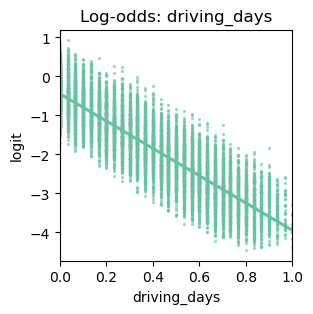

In [65]:
# Gráfico de regressão para log-odds

plt.figure(figsize=(3, 3))
sns.regplot(x='driving_days', y='logit', data=logit_data, scatter_kws={'s': 2, 'alpha': 0.5})
plt.title('Log-odds: driving_days');

# **Interpretação dos resultados do modelo**

Se as hipóteses logísticas forem satisfeitas, os resultados do modelo podem ser interpretados de maneira apropriada. Agora, avancemos para a realização de previsões utilizando os dados de teste.

In [66]:
# Obtemos as previsões

y_preds = model.predict(X_test)

Calculamos a precisão do modelo usando o método `score()` com `X_test` e `y_test` como seus dois argumentos. O método `score()` automatiza a previsão de dados usando `X_test` e os compara com `Y_test` e, por padrão, usa a métrica `R-quadrado`. A melhor pontuação possível é $1.0$.

In [67]:
model.score(X_test, y_test)

0.8251748251748252

Em seguida, calculamos a matriz de confusão com `y_test` e `y_preds` como seus argumentos, e visualizamos a matriz.

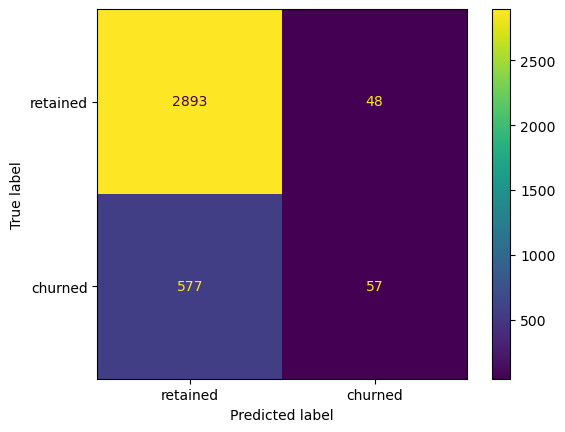

In [68]:
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['retained', 'churned'],
                              )
disp.plot();

Podemos calcular as métricas _precisão_ e _recall_ manualmente e comparar os resultados com os resultados da função [`classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) do scikit-learn.

In [83]:
# Calculamos precisão e recall manualmente

precision = cm[1,1] / (cm[0, 1] + cm[1, 1])
recall = cm[1,1] / (cm[1, 0] + cm[1, 1])
print("Presicão: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

Presicão: 0.54
Recall: 0.09


In [69]:
# Criar classification report

target_labels = ['retained', 'churned']
print(classification_report(y_test, y_preds, target_names=target_labels))

              precision    recall  f1-score   support

    retained       0.83      0.98      0.90      2941
     churned       0.54      0.09      0.15       634

    accuracy                           0.83      3575
   macro avg       0.69      0.54      0.53      3575
weighted avg       0.78      0.83      0.77      3575



In [95]:
accuracy = accuracy_score(y_test, y_preds)
print("Acurácia: {:.2f}".format(accuracy))

Acurácia: 0.83


Observamos que o modelo apresenta uma precisão mediana e um recall bastante baixo, indicando que ele tem a tendência de realizar muitas previsões falsas negativas e não consegue identificar com acurácia os usuários que estão propensos a abandonar o aplicativo. Nesse projeto, desenvolvemos também um modelo sem a aplicação de normalização de dados, contudo, essa abordagem não apresentou melhorias nos resultados obtidos. 

Por fim, construimos um gráfico de barras dos coeficientes do modelo, proporcionando uma representação visual da importância dos recursos no modelo.

In [92]:
# Criamos uma lista de tuplas (column_name, coeficiente)
feature_importance = list(zip(X_train.columns, model.coef_[0]))

# Ordenamos a lista por valor do coeficiente
feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
feature_importance

[('drives', 0.548754237358604),
 ('total_navigations_fav1', 0.5288430755659492),
 ('duration_minutes_drives', 0.49871339886505184),
 ('km_per_driving_day', 0.2111985830607465),
 ('total_sessions', 0.16651353470252145),
 ('total_navigations_fav2', 0.12679629625596897),
 ('device2', 0.018193513391316585),
 ('professional_driver', 0.014553484821642376),
 ('driven_km_drives', -0.08928132961371837),
 ('sessions', -0.17534396875697736),
 ('driving_days', -0.8253606066626871),
 ('n_days_after_onboarding', -1.3812057530343071),
 ('activity_days', -2.5533496806301264)]

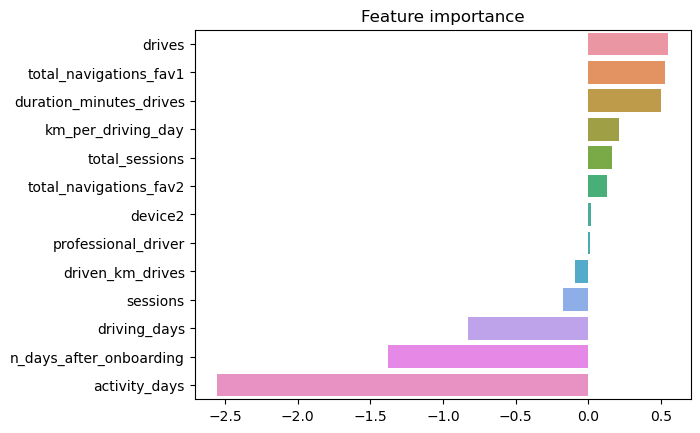

In [93]:
# Criamos o gráfico

sns.barplot(x=[x[1] for x in feature_importance],
            y=[x[0] for x in feature_importance],
            orient='h')
plt.title('Feature importance');

## Bonus: balanceamento de dados 

Como foi mencionado anterior, construir um modelo de regressão logística com a variável desbalanceada pode dar alguns problemas. Isso acontece porque o padrão dos dados para a classe dominante vai se sobressair em relação aos da classe com menor frequência. No nosso caso, a classe com menor frequência - churn - é justamente a que temos interesse em prever, o que torna os problemas ainda maiores. 

Para contornar esse problema gerado pela base de dados desbalanceada, podemos recorrer a uma técnica chamada "_Undersampling"_, consiste em diminuir a quantidade de registros da classe com maior frequência até que a base de dados possua uma quantidade equilibrada entre as classes da variável alvo.

Usamos o módulo `RandomUnderSampler` do pacote `imblearn`.

In [83]:
# Instanciamos o RandomUnderSampler
rus = RandomUnderSampler(random_state=42, sampling_strategy="majority")

# Aplicamos o RandomUnderSampler 
X_under, y_under = rus.fit_resample(X_train, y_train)

In [91]:
# Visualizamos o tamanho dos dados balanceados

print(np.shape(y_train))
print(np.shape(y_under))

(10724,)
(3804,)


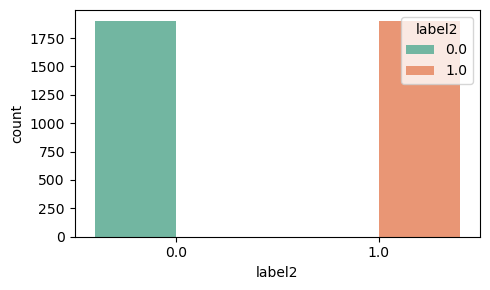

In [95]:
# Gráfico da distribuição nova de classes

plt.figure(figsize=(5,3))
sns.countplot(x=y_under, hue=y_under)
plt.tight_layout()

Utilizamos o scikit-learn para instanciar e ajustar um modelo de regressão logística com dados balanceados.

In [85]:
model = LogisticRegression(max_iter=400)

model.fit(X_under, y_under)

LogisticRegression(max_iter=400)

In [87]:
# Obtemos as previsões
y_preds_= model.predict(X_under)

# Visualizamos as métricas
target_labels = ['retained', 'churned']
print(classification_report(y_under, y_preds_, target_names=target_labels))

              precision    recall  f1-score   support

    retained       0.70      0.67      0.69      1902
     churned       0.69      0.72      0.70      1902

    accuracy                           0.69      3804
   macro avg       0.69      0.69      0.69      3804
weighted avg       0.69      0.69      0.69      3804



In [88]:
accuracy = accuracy_score(y_under, y_preds_)
print("Acurácia: {:.2f}".format(accuracy))

Acurácia: 0.69


As métricas melhoraram!

# **Conclusões Finais**

Neste projeto, desenvolvemos e avaliamos um modelo de regressão logística com o objetivo de antecipar a rotatividade de usuários do aplicativo Waze. Utilizamos diversas variáveis como base para a previsão.

Inicialmente, realizamos uma análise exploratória de dados, incluindo histogramas e gráficos de dispersão, para extrair indicadores relevantes. A visualização de dados confirmou a hipótese de que, embora duas variáveis `driving_days` e `activity_days` estejam relacionadas, elas não são idênticas

Em seguida, conduzimos o pré-processamento de dados, um passo importante na construção de um modelo robusto. Solucionamos problemas relacionados à presença de valores ausentes e outliers, uma vez que estes podem impactar significativamente o desempenho de um modelo de regressão logística. Lidamos com os outliers calculando o $95º$ percentil de cada coluna e substituindo os valores que excediam esse limite. Além disso, introduzimos novas variáveis, `km_per_driving_day` e `professional_driver`, para abordar especificamente os desafios do nosso projeto.

Para a seleção de variáveis preditoras, utilizamos a matriz de correlação de Pearson. Identificamos multicolinearidade entre as variáveis `sessions` e `drives` (coeficiente de correlação igual a 1.0) e entre `driving_days` e `activity_days` (coeficiente de correlação de 0.95). Optamos por descartar as variáveis `sessions` e `driving_days` na construção do modelo.

Após a construção do modelo, avaliamos seu desempenho através da pontuação do modelo, métricas de precisão e recall, e a matriz de confusão. Observamos que o modelo possui uma precisão mediana (53% de suas previsões positivas estão corretas) e um recall bastante baixo (apenas 9%), indicando uma tendência a realizar muitas previsões falsas negativas, não identificando com acurácia os usuários propensos a abandonar o aplicativo.

Finalmente, criamos um gráfico de barras dos coeficientes do modelo, oferecendo uma representação visual da importância dos recursos. Diante disso, destacamos alguns pontos-chave:

*    A variável mais influente na previsão do modelo é `activity_days`, representando o número de dias em que o usuário abre o aplicativo durante o mês, com uma correlação negativa em relação à rotatividade de usuários.

*    Em modelos de regressão logística múltipla, as interações entre variáveis podem resultar em relações aparentemente contra-intuitivas, sendo tanto uma vantagem quanto uma limitação na explicabilidade do modelo.

*    Apesar do modelo não apresentar uma capacidade preditiva forte, sua utilização pode orientar futuras investigações exploratórias.

*    Sugere-se a implementação de novos recursos para aprimorar o valor preditivo. O recurso `professional_driver` se destacou como o terceiro preditor mais significativo. 

*    Informações adicionais sobre cada usuário, como tempos de viagem e localizações geográficas, seriam benéficas. Detalhes sobre a interação dos usuários com o aplicativo, como a frequência de comunicação ou confirmação de alertas de perigo na estrada, também poderiam enriquecer o modelo.